In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt

from typing import Optional

2022-10-12 09:05:22.363379: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-12 09:05:22.939210: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-12 09:05:22.939253: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-12 09:05:23.000252: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-12 09:05:24.513256: W tensorflow/stream_executor/platform/de

In [2]:
from src.data import load_data_generator
from src.regularizer import EvidenceRegularizer, EvidenceRegularizerLayer

In [3]:
dtrain, dtest = load_data_generator(name='cifar10', batch_size=1024, augment=True)

2022-10-12 09:05:37.086751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-12 09:05:37.087153: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-12 09:05:37.087276: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-12 09:05:37.087337: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-12 09:05:37.087396: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [4]:
def cifar_10_no_regularization():
    model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(32,32,3)),
    keras.layers.Dense(1024, activation='tanh'),
    keras.layers.Dense( 512, activation='tanh'),
    keras.layers.Dense( 256, activation='tanh'),
    keras.layers.Dense( 128, activation='tanh'),
    keras.layers.Dense(  64, activation='tanh'),
    keras.layers.Dense(  10, activation='softmax')])
    return model

def add_regularization(vanilla_model, regularizer = None, layers = None, **kwargs):   
    model = keras.models.Sequential()
    if layers is None:
        layers = range(1, len(vanilla_model.layers)-1)
    for i, l in enumerate(vanilla_model.layers):
        model.add(l)
        if i in layers:
            if regularizer is None:
                pass
            elif regularizer == 'l1':
                l.kernel_regularizer = keras.regularizers.l1(**kwargs)
            elif regularizer == 'l2':
                l.kernel_regularizer = keras.regularizers.l2(**kwargs)
            elif regularizer == 'dropout':
                model.add(keras.layers.Dropout(**kwargs))
            elif regularizer == 'evidence':
                l.activity_regularizer = EvidenceRegularizer(**kwargs)
            elif regularizer == 'evidence_layer':
                model.add(EvidenceRegularizerLayer(**kwargs))
            else:
                raise ValueError("Unknown regularizer: %s" % regularizer)
    return model

def create_all_models(vanilla_model_fun):
    model = vanilla_model_fun()
    l1 = add_regularization(vanilla_model=vanilla_model_fun(), regularizer='l1')
    l2 = add_regularization(vanilla_model=vanilla_model_fun(), regularizer='l2')
    dropout = add_regularization(vanilla_model=vanilla_model_fun(), regularizer='dropout', layers=[0], rate=0.5)
    evidence = add_regularization(vanilla_model=vanilla_model_fun(), regularizer='evidence', threshold=100, cutoff=0.0, strength=1.0)
    init_evidence = add_regularization(vanilla_model=vanilla_model_fun(), regularizer='evidence', layers=[1], threshold=100, cutoff=0.0, strength=1.0)

    return {'None': model, 'L1': l1, 'L2': l2, 'Dropout': dropout, 'Evidence-based': evidence, 'Evidence-based_1': init_evidence}

def compile_and_fit_model(model, dtrain, dtest, compile_kwargs: Optional[dict] = None, fit_kwargs: Optional[dict] = None):
    _compile_kwargs = dict(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
    if compile_kwargs is not None:
        _compile_kwargs.update(**compile_kwargs)
    model.compile(**_compile_kwargs)

    _fit_kwargs = dict(x=dtrain, validation_data=dtest, epochs=50)
    if fit_kwargs is not None:
        _fit_kwargs.update(**fit_kwargs)
    
    history = model.fit(**_fit_kwargs)

    return history
    

In [5]:
models = create_all_models(cifar_10_no_regularization)

In [6]:
histories = {key: compile_and_fit_model(model=m, dtrain=dtrain, dtest=dtest) for key, m in models.items()}

Epoch 1/50
49/49 [==============================] - 26s 511ms/step - loss: 1.9885 - accuracy: 0.2907 - val_loss: 1.8352 - val_accuracy: 0.3627
Epoch 2/50
49/49 [==============================] - 24s 482ms/step - loss: 1.8206 - accuracy: 0.3645 - val_loss: 1.7703 - val_accuracy: 0.3885
Epoch 3/50
49/49 [==============================] - 24s 488ms/step - loss: 1.7702 - accuracy: 0.3813 - val_loss: 1.7666 - val_accuracy: 0.3872
Epoch 4/50
49/49 [==============================] - 21s 435ms/step - loss: 1.7402 - accuracy: 0.3967 - val_loss: 1.7280 - val_accuracy: 0.4021
Epoch 5/50
49/49 [==============================] - 21s 431ms/step - loss: 1.7179 - accuracy: 0.4047 - val_loss: 1.7149 - val_accuracy: 0.4064
Epoch 6/50
49/49 [==============================] - 21s 437ms/step - loss: 1.6889 - accuracy: 0.4141 - val_loss: 1.6954 - val_accuracy: 0.4141
Epoch 7/50
49/49 [==============================] - 21s 433ms/step - loss: 1.6690 - accuracy: 0.4215 - val_loss: 1.6801 - val_accuracy: 0.4243

In [8]:
def plot_histories(histories: dict):
    fig, ax = plt.subplots(2, 2, figsize=(14,12), tight_layout=True, sharex=True, sharey='row')
    for name, history in histories.items():
        _ = ax[0,0].plot(history.history['accuracy'], label=name)
        _ = ax[0,1].plot(history.history['val_accuracy'], label=name)
        _ = ax[1,0].plot(history.history['loss'], label=name)
        _ = ax[1,1].plot(history.history['val_loss'], label=name)

    ax[0,0].set_ylabel('Accuracy')
    ax[0,1].set_ylabel('Accuracy')
    ax[1,0].set_ylabel('Loss')
    ax[1,1].set_ylabel('Loss')

    ax[0,0].set_title('Training Data')
    ax[0,1].set_title('Test Data')
    ax[1,0].set_title('Training Data')
    ax[1,1].set_title('Test Data')

    ax[0,0].legend()

    return fig, ax


(<Figure size 1400x1200 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'Training Data'}, ylabel='Accuracy'>,
         <AxesSubplot:title={'center':'Test Data'}, ylabel='Accuracy'>],
        [<AxesSubplot:title={'center':'Training Data'}, ylabel='Loss'>,
         <AxesSubplot:title={'center':'Test Data'}, ylabel='Loss'>]],
       dtype=object))

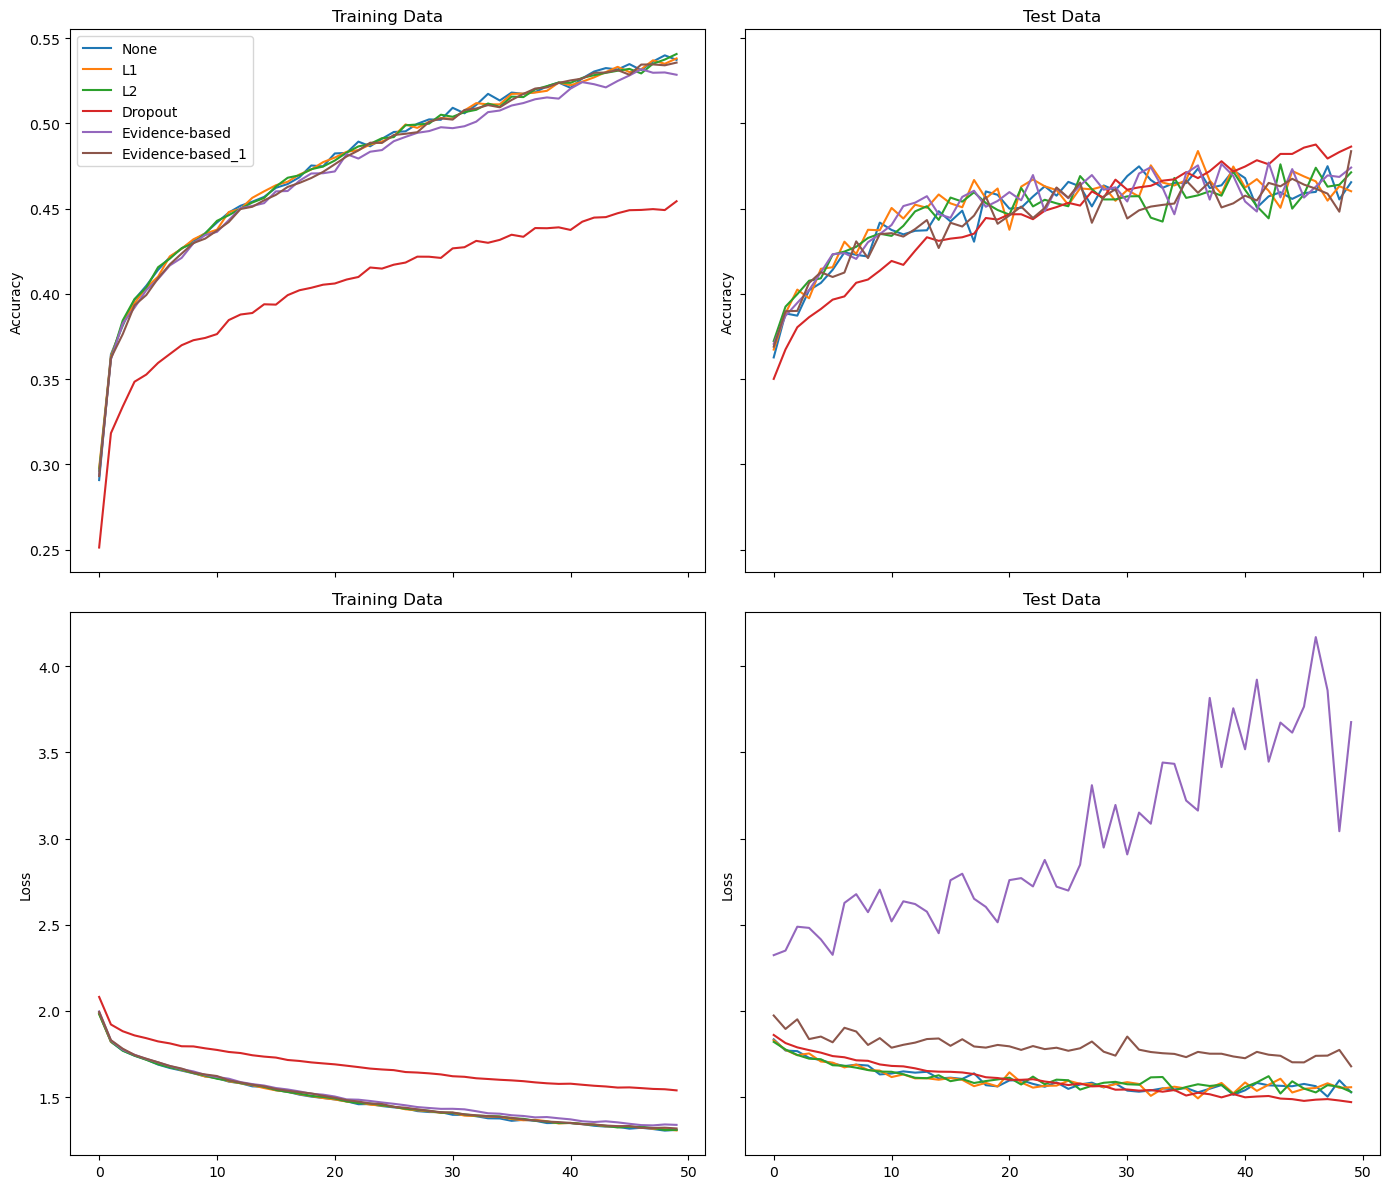

In [9]:
plot_histories(histories)

In [11]:
compile_kwargs = dict(optimizer=keras.optimizers.SGD(learning_rate=0.1, momentum=0.9))
histories_faster = {key: compile_and_fit_model(model=m, dtrain=dtrain, dtest=dtest, compile_kwargs=compile_kwargs) for key, m in models.items()}

Epoch 1/50
49/49 [==============================] - 29s 569ms/step - loss: 1.7460 - accuracy: 0.3962 - val_loss: 1.5840 - val_accuracy: 0.4445
Epoch 2/50
49/49 [==============================] - 27s 559ms/step - loss: 1.5503 - accuracy: 0.4494 - val_loss: 1.6097 - val_accuracy: 0.4300
Epoch 3/50
49/49 [==============================] - 29s 582ms/step - loss: 1.4980 - accuracy: 0.4692 - val_loss: 1.4923 - val_accuracy: 0.4763
Epoch 4/50
49/49 [==============================] - 29s 583ms/step - loss: 1.4699 - accuracy: 0.4784 - val_loss: 1.4640 - val_accuracy: 0.4764
Epoch 5/50
49/49 [==============================] - 27s 560ms/step - loss: 1.4527 - accuracy: 0.4849 - val_loss: 1.4762 - val_accuracy: 0.4777
Epoch 6/50
49/49 [==============================] - 28s 574ms/step - loss: 1.4391 - accuracy: 0.4899 - val_loss: 1.4457 - val_accuracy: 0.4902
Epoch 7/50
49/49 [==============================] - 28s 569ms/step - loss: 1.4343 - accuracy: 0.4902 - val_loss: 1.5009 - val_accuracy: 0.4702

(<Figure size 1400x1200 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'Training Data'}, ylabel='Accuracy'>,
         <AxesSubplot:title={'center':'Test Data'}, ylabel='Accuracy'>],
        [<AxesSubplot:title={'center':'Training Data'}, ylabel='Loss'>,
         <AxesSubplot:title={'center':'Test Data'}, ylabel='Loss'>]],
       dtype=object))

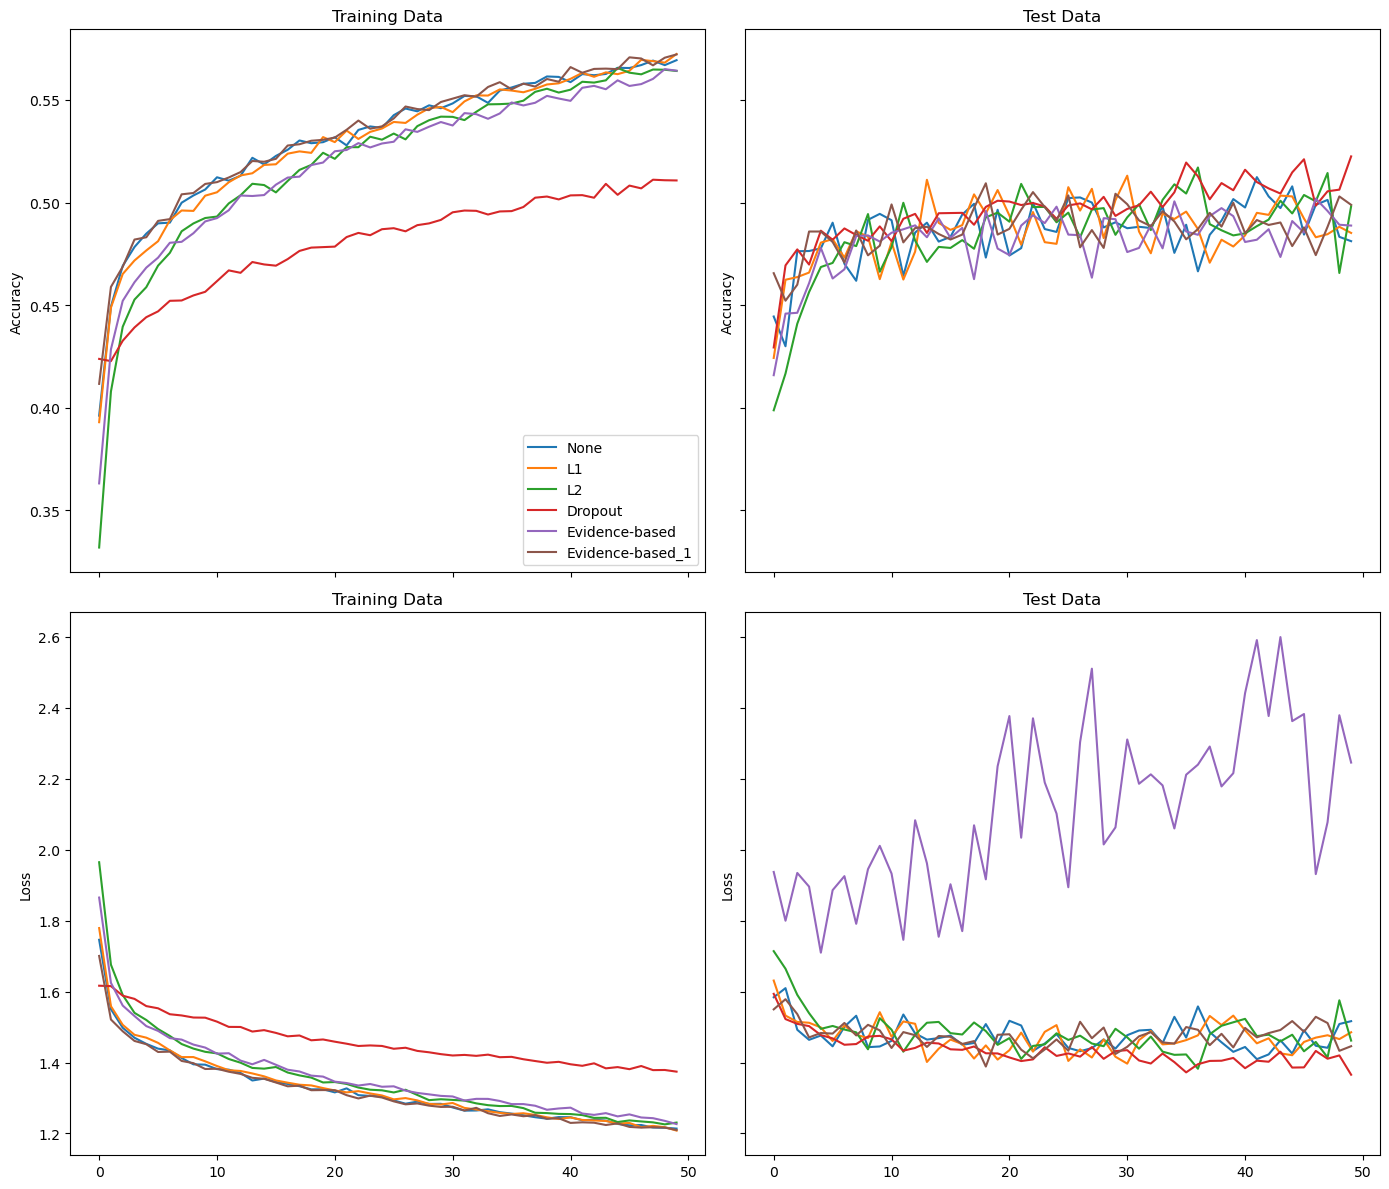

In [12]:
plot_histories(histories_faster)

Text(0, 0.5, 'Loss')

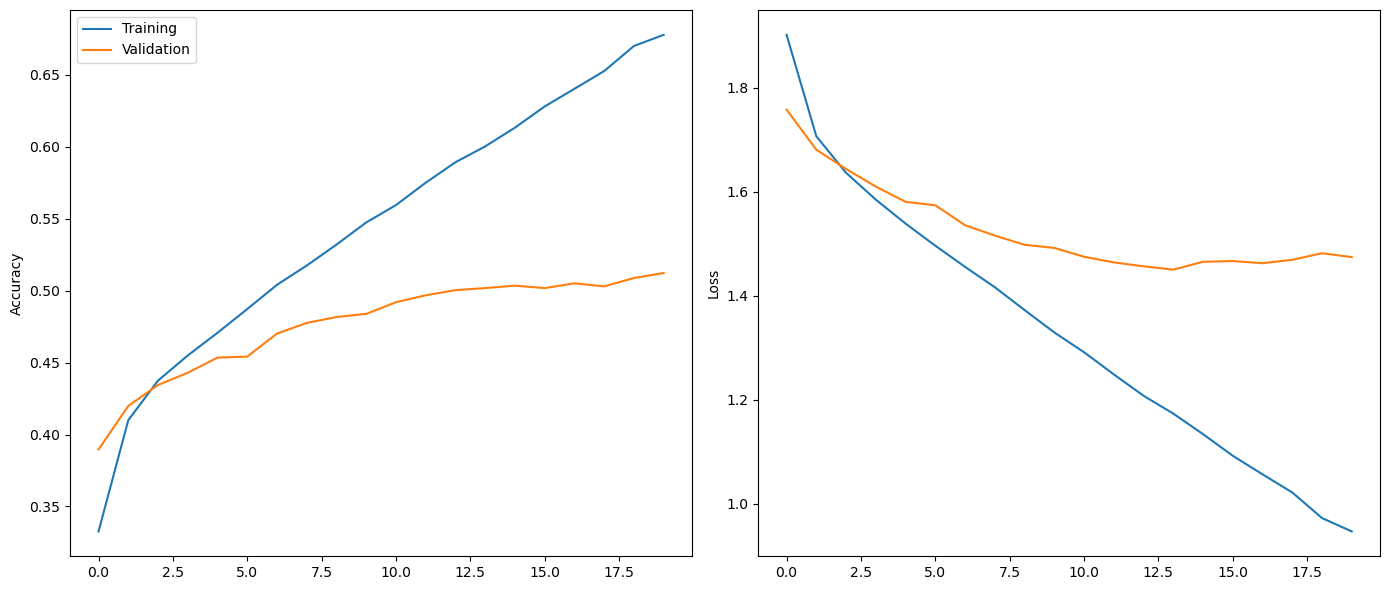

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(14,6), tight_layout=True)
line1 = ax[0].plot(history.history['accuracy'], label='Training')
line2 = ax[0].plot(history.history['val_accuracy'], label='Validation')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
_ = ax[1].plot(history.history['loss'])
_ = ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')